# Meteogram data of the adiabatic warming test

In [1]:
import sys
import os
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path:
    sys.path.append(module_path)
import file_handling as fh
fh.disable_warnings()

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
from matplotlib.patches import Rectangle, Circle
from matplotlib.collections import PatchCollection
import cartopy.feature as cfeature
import numpy as np
import meteogram_extract_stations as mes


def get_path(experiment):
    # if   experiment == 'warming': return '/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/4kadiabat'
    if   experiment == 'warming': return '/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/4kadiabat2'
    elif experiment == 'rerun'  : return '/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/r02EUREC4A'

def meteogram(experiment_path=get_path('warming'), station='BCO', domain='DOM01', rm_temp=False):
    # mes.create_ncfile(infile, outfile, station, variables=None, verbose=False)
    ifile = [os.path.join(experiment_path,f) for f in os.listdir(experiment_path) if 'Meteo' in f and domain in f][0]
    ofile = f'/scratch/m/m300872/temp/meteo_4kadiabat_{station}.nc'
    mes.create_ncfile(ifile,ofile,station)
    dataset = xr.open_dataset(ofile)
    if rm_temp: os.remove(ofile)
    return dataset

def meteogram_print_vars(meteogram=meteogram()):
    for var in list(meteogram):
        try: print(var.ljust(8), meteogram[var].long_name.ljust(16))
        except: pass

def rectangle_anker(grid):
    lonlim = [np.rad2deg(l) for l in (np.min(grid.clon.values), np.max(grid.clon.values))]
    latlim = [np.rad2deg(l) for l in (np.min(grid.clat.values), np.max(grid.clat.values))]
    anker  = (lonlim[0], latlim[0]) # Rectangle demands coordinates for lower left corner + height and width
    extent = (lonlim[1] - lonlim[0], latlim[1] - latlim[0])
    return anker, extent

def add_map_view(ax, map_projection, latlon_limits, colored_map=False, gridlines=True):
    # decorations
    ax.coastlines()
    if colored_map:
        # (https://techoverflow.net/2021/04/25/how-to-add-colored-background-to-cartopy-map/)
        ax.stock_img()
    else:
        # or just color the land:
        ax.add_feature(cfeature.LAND, facecolor='black', alpha=0.4)
    ax.set_extent(latlon_limits, ccrs.PlateCarree())
    if gridlines:
        ax.gridlines(draw_labels=True, crs=map_projection)

def add_rectangles(ax, rectangles):
    # Create patch collection with specified colour/alpha, inside the loop, because it can not be reused
    pc = PatchCollection(rectangles, facecolor='none', alpha=1, edgecolor='blue', linewidth=2, zorder=2)    
    ax.add_collection(pc)
    
def eureca_domain_rectangles(domains=['DOM01','DOM02'],):
    # get extents of grids as rectangles
    rectangles = list()
    for dom in ['DOM01','DOM02']:
        grid = xr.open_zarr(f"https://swift.dkrz.de/v1/dkrz_948e7d4bbfbb445fbff5315fc433e36a/grids/EUREC4A_PR1250m_{dom}.zarr")
        anker, extent = rectangle_anker(grid)
        rectangles.append(Rectangle(anker, *extent))
    return rectangles
    
def plot_grid_rectangles(latlon_limit_list):
    projection = ccrs.PlateCarree(central_longitude=0)
    fig = plt.figure(figsize=[20, 10])
    axs = list()

    for i, latlon_limit in enumerate(latlon_limit_list): 
        ax = fig.add_subplot(1, len(latlon_limit_list)+1, i+1, projection=projection)
        add_map_view(ax, projection, latlon_limit)
        add_rectangles(ax, eureca_domain_rectangles())
        axs.append(ax)

    return fig, axs

def figure_meteogram_locations():
    experiment_path=get_path('warming')
    domain='DOM01'
    ifile = [os.path.join(experiment_path,f) for f in os.listdir(experiment_path) if 'Meteo' in f and domain in f][0]
    dataset = xr.open_dataset(ifile)

    fig, axs = plot_grid_rectangles([(-62,-44,+6,+18)])
    ax = axs[0]
    
    for i in range(7):
        if dataset['station_name'].values[i] == b'c_center' : xy_center = (dataset['station_lon'].values[i], dataset['station_lat'].values[i])
        if dataset['station_name'].values[i] == b'c_south'  : xy_south  = (dataset['station_lon'].values[i], dataset['station_lat'].values[i])
    radius = np.abs(xy_center[1] - xy_south[1])
    circle = Circle(xy_center, radius, facecolor='none', alpha=1, edgecolor='blue', linewidth=0.8, ls=':', label='Halo circle')
    ax.add_patch(circle)

    for dom in ['DOM01','DOM02']:
        grid = xr.open_zarr(f"https://swift.dkrz.de/v1/dkrz_948e7d4bbfbb445fbff5315fc433e36a/grids/EUREC4A_PR1250m_{dom}.zarr")
        anker, extent = rectangle_anker(grid)
        ax.annotate(dom, (anker[0], anker[1]+extent[1]), xytext=(-2,5), textcoords='offset pixels')

    for i in range(7):
        xy = (dataset['station_lon'].values[i], dataset['station_lat'].values[i])
        name = dataset['station_name'].values[i].decode("utf-8")
        if name[0:2] == 'c_' : name = name[2::]
        if i == 0: label='Meteogram stations'
        else: label=None
        ax.scatter(*xy, color='blue', s=30, marker='+', label=label)
        ax.annotate(name, xy, xytext=(-2,5), textcoords='offset pixels')
    
    ax.set_title('Location of meteogram stations')
    return fig, axs

The available meteogram stations are positioned at points of interest for the EUREC4A field campaign: The surface buoy [NTAS](https://eurec4a.eu/platforms/ntas-buoy), the barbados cloud observatory ([BCO](https://eurec4a.eu/platforms/bco)) and along the circle of on which the [HALO aircraft](https://eurec4a.eu/platforms/halo) flew and launched drop sonds.

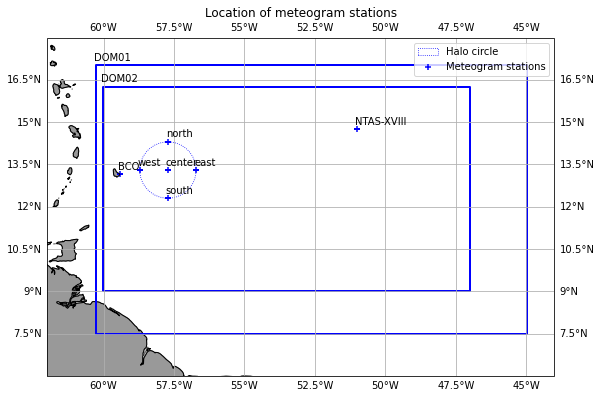

In [3]:
fig, axs = figure_meteogram_locations()
axs[0].legend()
fig.savefig('img/meteogram_station_map.svg')
fig.show()

In [46]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt

def plot_meteogram_timeseries_profile(fig, ax, array, cmap = 'bwr', var_info=False):
    vmax = max([-np.nanmin(array), np.nanmax(array)])
    im = ax.imshow(array,cmap=cmap, vmin=-vmax, vmax=vmax)
    ax.set_xlabel('time / min')
    ax.set_ylabel('model level')
    ax.set_xlim(0,array.shape[1])

    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    label = 'Difference to $t_0$'
    if var_info: label=f'Difference in {var_info["name"]} to $t_0$ / {var_info["unit"]}' 
    plt.colorbar(im, cax=cax, orientation='vertical', label=label)
    return fig, ax

def figure_meteogram_single(meteogram, varname):
    y = meteogram[varname].values
    y_mean  = np.asarray([y.mean(axis=0) for i in range(y.shape[0])])
    y_diff = y - y_mean
    y_first = np.asarray([y[0] for i in range(y.shape[0])])
    y_diff = y - y_first
    array = y_diff.transpose()

    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)
    var_info = {'name' : meteogram[varname].long_name, 'unit' : meteogram[varname].units}
    fig, ax = plot_meteogram_timeseries_profile(fig, ax, array, var_info=var_info)
    return fig, ax

def figure_meteogram_quad(meteogram, varname):
    fig = plt.figure(figsize=(20, 12))
    for i, e in enumerate(varname):
        y = meteogram[e].values
        y_mean  = np.asarray([y.mean(axis=0) for i in range(y.shape[0])])
        y_diff = y - y_mean
        y_first = np.asarray([y[0] for i in range(y.shape[0])])
        y_diff = y - y_first
        array = y_diff.transpose()
        
        ax = fig.add_subplot(221 + i)
        var_info = {'name' : meteogram[e].long_name, 'unit' : meteogram[e].units}
        fig, ax = plot_meteogram_timeseries_profile(fig, ax, array, var_info=var_info)
    return fig, ax

A first look into the meteogram (BCO) reveals the adjustment of the vertical column after startup, with warming in the uppermost layers and cooling in the Troposphere. This cooling is somewhat around 1 degree (see analysis of domain means), but can get more pronounced in certail layers of under clouds. 

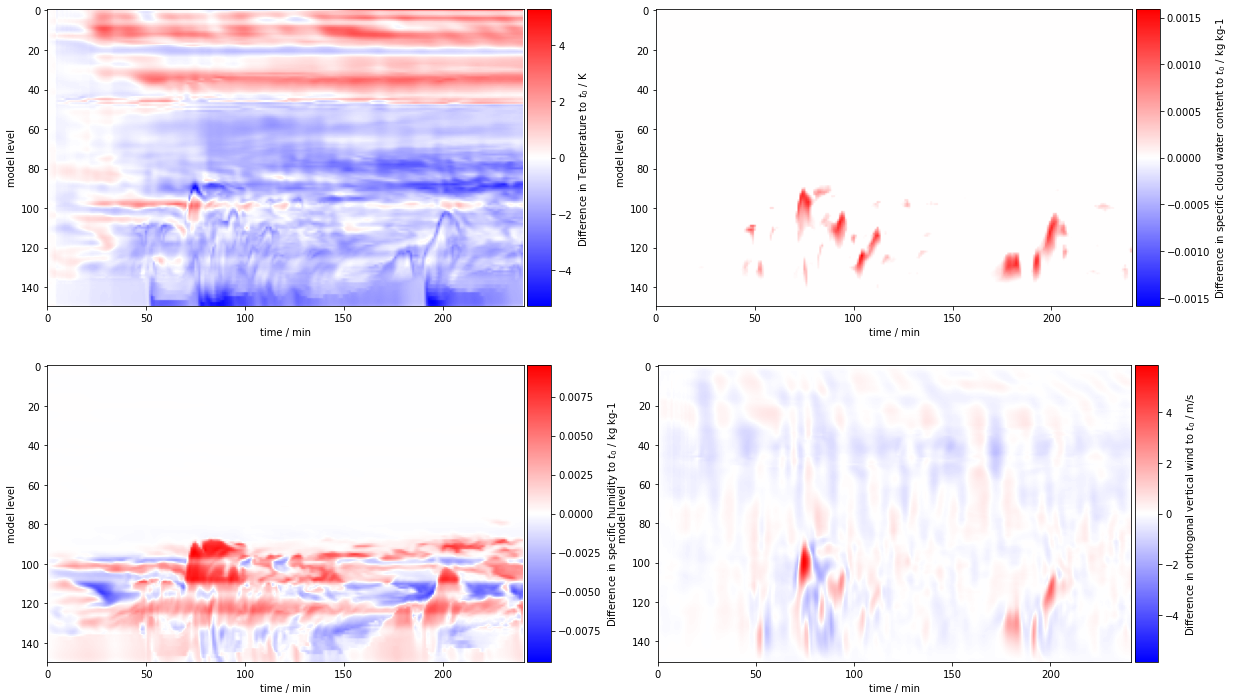

In [47]:
fig, ax = figure_meteogram_quad(meteogram(), ['T', 'QC', 'QV', 'W'])
fig.show()

The NTAS meteogram is more upwind. It shows the same pattern, but less pronounced.

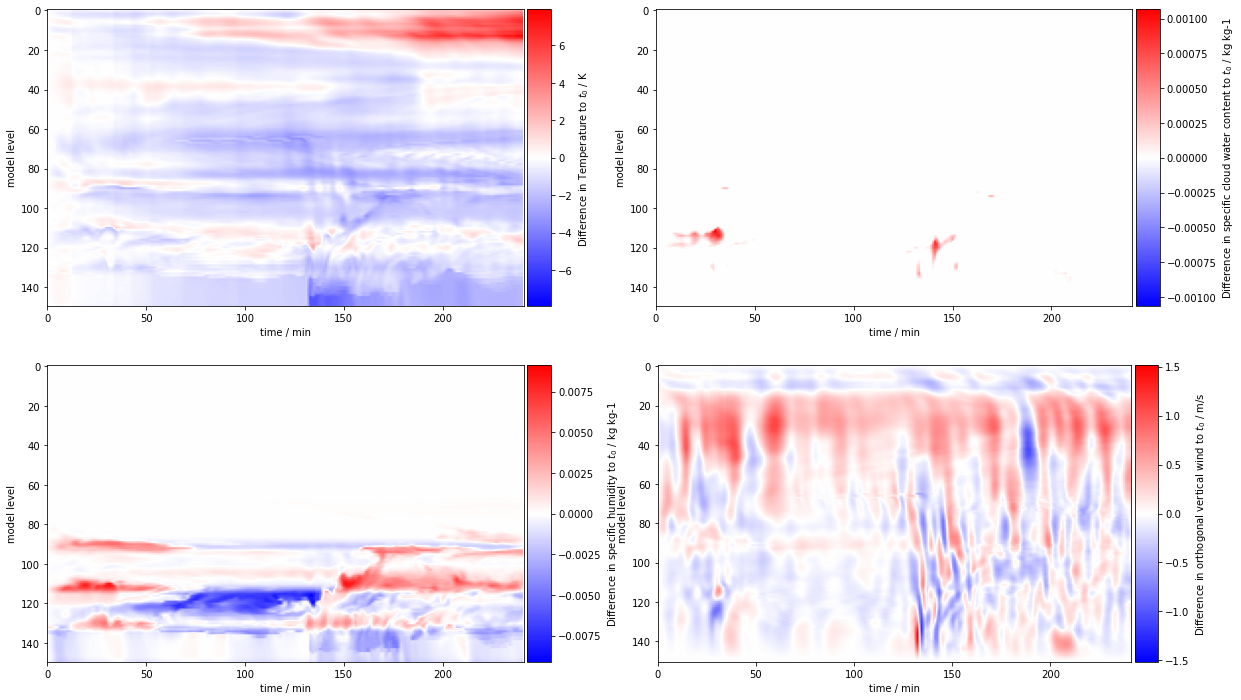

In [48]:
fig, ax = figure_meteogram_quad(meteogram(station='NTAS-XVIII'), ['T', 'QC', 'QV', 'W'])
fig.show()

In [49]:
def figure_meteogram_quad_station(stations, varname, experiment_path=get_path('warming'), domain='DOM01'):
    meteograms = [meteogram(station=s, experiment_path=experiment_path, domain=domain)[varname] for s in stations]

    fig = plt.figure(figsize=(20, 12))
    for i, e in enumerate(meteograms):
        y = e.values
        y_mean  = np.asarray([y.mean(axis=0) for i in range(y.shape[0])])
        y_diff = y - y_mean
        y_first = np.asarray([y[0] for i in range(y.shape[0])])
        y_diff = y - y_first
        array = y_diff.transpose()
    
        ax = fig.add_subplot(311 + i)
        var_info = {'name' : e.long_name, 'unit' : e.units}
        fig, ax = plot_meteogram_timeseries_profile(fig, ax, array, var_info=var_info)
        ax.set_title(stations[i], loc='left')
    return fig, ax

If there is a gradual spin up as the air moves into the domain (northeast to southwest), this should be visible in the comparison of meteograms along the way.

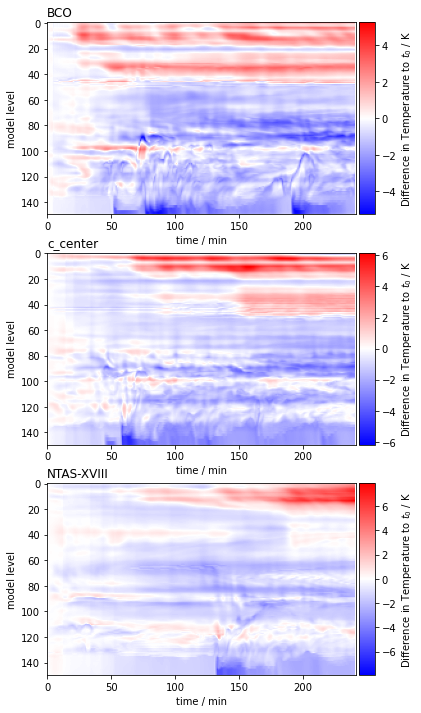

In [50]:
experiment_path=get_path('warming')
domain='DOM01'
stations = ['BCO', 'c_center', 'NTAS-XVIII']
varname = 'T'
figure_meteogram_quad_station(stations, varname)
plt.show()

It might be a good idea to define additional meteogram stations to facilitate this type of analysis:

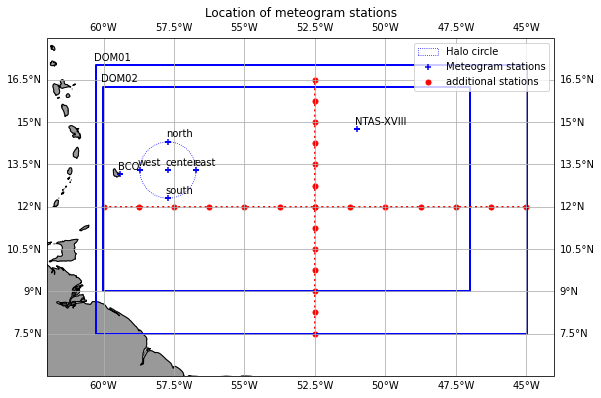

In [51]:
def station_line(lat_range, lon_range, n, name_prefix=''):
    stations = list()
    for i in range(n):
        station = dict()
        station['lat']  = np.linspace(*lat_range, n)[i]
        station['lon']  = np.linspace(*lon_range, n)[i]
        station['name'] = f'{name_prefix}{str(i).rjust(2,"0")}'
        stations.append(station)
    return stations

def fig_proposed_meteogram_stations(label='additional stations'):
    vertical   = station_line((7.5, 16.5), (-52.5, -52.5), 13, 'v_')
    horizontal = station_line((12,12), (-60.0, -45.0), 13, 'h_')

    fig, axs = figure_meteogram_locations()
    ax = axs[0]
    for stat in vertical + horizontal:
        if stat == vertical[0]: effectivelabel=label
        else: effectivelabel=None
        ax.scatter(stat['lon'], stat['lat'], color='red', s=100, marker='.', label=effectivelabel)
    for axis in vertical, horizontal:
        ax.plot([axis[0]['lon'], axis[-1]['lon']], [axis[0]['lat'], axis[-1]['lat']], color='red', linestyle=':', lw=2)
    ax.legend(facecolor="white")
    return fig, axs

fig, axs = fig_proposed_meteogram_stations()

In [52]:
def print_stations_for_namelist():
    vertical   = station_line((7.5, 16.5), (-52.5, -52.5), 13, 'v_')
    horizontal = station_line((12,12), (-60.0, -45.0), 13, 'h_')

    for s in vertical + horizontal:
        print(' '*22 + f'{s["lat"]:.2f}'.rjust(5) + ', ' + f'{s["lon"]:.2f}, \'{s["name"]}\',')

print_stations_for_namelist()

                       7.50, -52.50, 'v_00',
                       8.25, -52.50, 'v_01',
                       9.00, -52.50, 'v_02',
                       9.75, -52.50, 'v_03',
                      10.50, -52.50, 'v_04',
                      11.25, -52.50, 'v_05',
                      12.00, -52.50, 'v_06',
                      12.75, -52.50, 'v_07',
                      13.50, -52.50, 'v_08',
                      14.25, -52.50, 'v_09',
                      15.00, -52.50, 'v_10',
                      15.75, -52.50, 'v_11',
                      16.50, -52.50, 'v_12',
                      12.00, -60.00, 'h_00',
                      12.00, -58.75, 'h_01',
                      12.00, -57.50, 'h_02',
                      12.00, -56.25, 'h_03',
                      12.00, -55.00, 'h_04',
                      12.00, -53.75, 'h_05',
                      12.00, -52.50, 'h_06',
                      12.00, -51.25, 'h_07',
                      12.00, -50.00, 'h_08',
          

In [53]:
def extract_meteogram(meteogram, varname, length=False, limit=False):
    y = meteogram[varname].values
    if limit: y = limit_values(y,limit)
    if length: y = y[0:length][...]
    if not length: length = y.shape[0]
    y_first = np.asarray([y[0] for i in range(length)])
    y_diff = y - y_first
    # array = center_around_zero(y_diff)
    array = y_diff.transpose()
    return array

def plot_meteogram_timeseries_profile(fig, ax, array, cmap = 'bwr', var_info=False, vmax=False, cbar=False):
    if not vmax: vmax = get_vmax(array)
    im = ax.imshow(array,cmap=cmap, vmin=-vmax, vmax=vmax)
    ax.set_xlabel('time / min')
    ax.set_ylabel('model level')
    ax.set_xlim(0,array.shape[1])
    if cbar:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        label = 'Difference to $t_0$'
        if var_info: label=f'Difference in {var_info["name"]} to $t_0$ / {var_info["unit"]}' 
        plt.colorbar(im, cax=cax, orientation='vertical', label=label)
    return fig, ax

def fig_warming_vs_control(station='BCO', varname='T', domain='DOM01'):
    fig = plt.figure(figsize=(20, 12))
    ax = fig.add_subplot(221 + 0)
    
    experiment = 'rerun'
    m = meteogram(experiment_path=get_path(experiment), station=station, domain=domain)
    y = extract_meteogram(m, varname, 241)
    var_info = {'name' : m[varname].long_name, 'unit' : m[varname].units}
    plot_meteogram_timeseries_profile(fig, ax, y, var_info=var_info, vmax=6)
    ax.set_title(f'Control')

    ax = fig.add_subplot(221 + 1)
    
    experiment = 'warming'
    m = meteogram(experiment_path=get_path(experiment), station=station, domain=domain)
    y2 = extract_meteogram(m, varname, 241)
    y = y - y2
    y = y2
    var_info = {'name' : m[varname].long_name, 'unit' : m[varname].units}
    plot_meteogram_timeseries_profile(fig, ax, y, var_info=var_info, vmax=6, cbar=True)
    ax.set_title(f'{experiment}, {station}')
    ax.set_title(f'Adiabatic warming (+4)')
    return fig

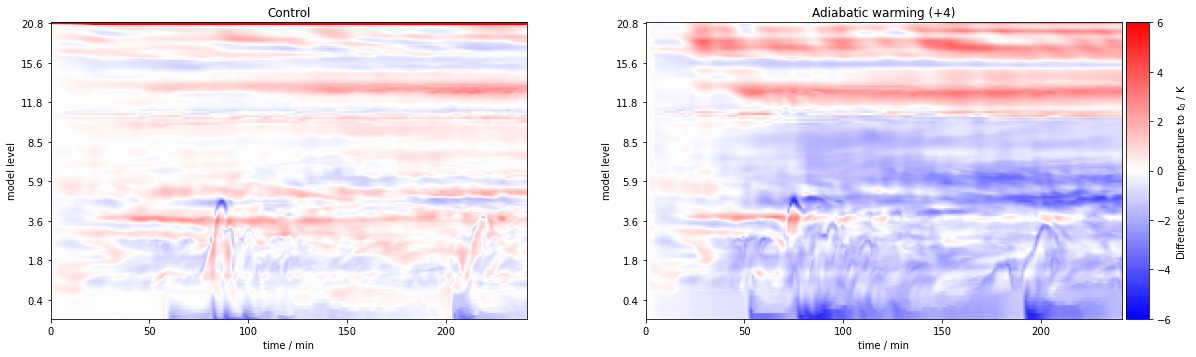

In [54]:
def fig_warming_vs_control(station='BCO', varname='T', domain='DOM01'):
    fig = plt.figure(figsize=(20, 12))
    axs = [fig.add_subplot(221 + 0), fig.add_subplot(221 + 1)]
    
    yticklabels=False
    yticklabels = [0,0,20,40,60,80,100,120,140] 
    
    m = meteogram(experiment_path=get_path('warming'), station=station, domain=domain)
    h = m.height_2.values
    yticklabels = [f'{h[i]/1000:.1f}' for i in yticklabels]
    
    ax = axs[0]
    experiment = 'rerun'
    m = meteogram(experiment_path=get_path(experiment), station=station, domain=domain)
    y = extract_meteogram(m, varname, 241)
    var_info = {'name' : m[varname].long_name, 'unit' : m[varname].units}
    discard, ax = plot_meteogram_timeseries_profile(fig, ax, y, var_info=var_info, vmax=6, yticklabels=yticklabels)   
    ax.set_title(f'Control')

    ax = axs[1]
    experiment = 'warming'
    m = meteogram(experiment_path=get_path(experiment), station=station, domain=domain)
    y2 = extract_meteogram(m, varname, 241)
    y = y - y2
    y = y2
    var_info = {'name' : m[varname].long_name, 'unit' : m[varname].units}
    discard, ax = plot_meteogram_timeseries_profile(fig, ax, y, var_info=var_info, vmax=6, cbar=True, yticklabels=yticklabels)
    ax.set_title(f'{experiment}, {station}')
    ax.set_title(f'Adiabatic warming (+4)')
    return fig

def plot_meteogram_timeseries_profile(fig, ax, array, cmap = 'bwr', var_info=False, vmax=False, cbar=False, yticklabels=False):
    if not vmax: vmax = get_vmax(array)
    im = ax.imshow(array,cmap=cmap, vmin=-vmax, vmax=vmax)
    ax.set_xlabel('time / min')
    ax.set_ylabel('model level')
    ax.set_xlim(0,array.shape[1])
    if yticklabels: ax.set_yticklabels(yticklabels)
    
    if cbar:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        label = 'Difference to $t_0$'
        if var_info: label=f'Difference in {var_info["name"]} to $t_0$ / {var_info["unit"]}' 
        plt.colorbar(im, cax=cax, orientation='vertical', label=label)
    return fig, ax

fig = fig_warming_vs_control()

Is this behaviour specific for the perturbed experiment, or does this happen in the control simulation, too?

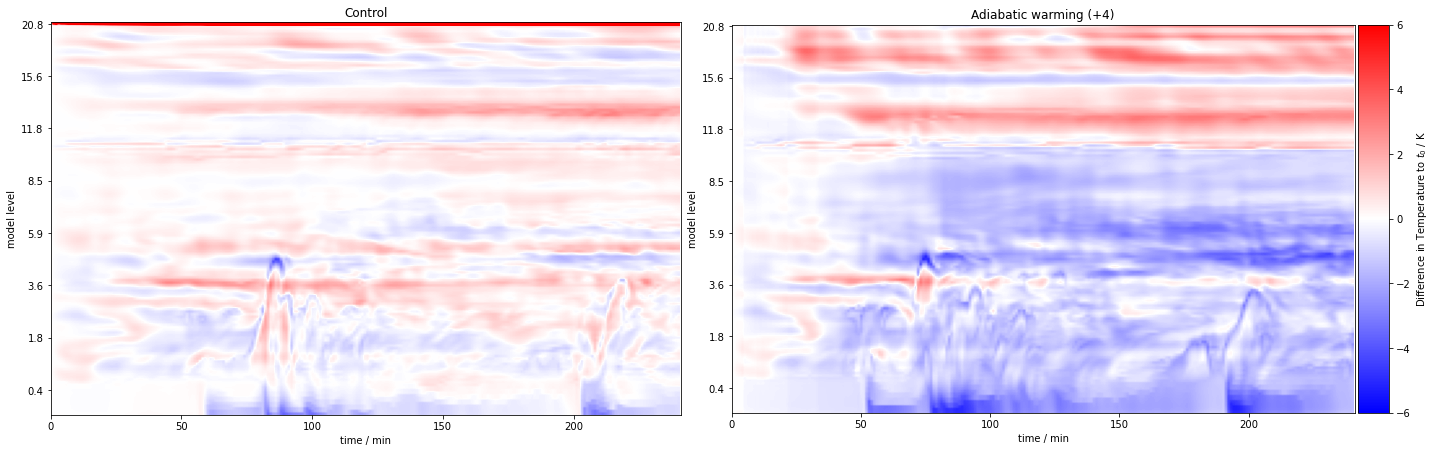

In [55]:
fig = fig_warming_vs_control()
plt.tight_layout()
fig.savefig('./img/meteogram_warming_vs_control.png', 
        bbox_inches=None, pad_inches=0.0)
plt.show()